### Imports

In [1]:
import os
import sys
import json
import boto3
import requests
import datetime
from tqdm.auto import tqdm
import asyncio
import aioboto3
from aiohttp import ClientSession
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
from io import StringIO
import pandas_market_calendars as mcal

import talib as ta

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/shriramsunder/Projects/Waves - All TimeSeries Related/")

from polygonio_api_calls import get_all_tickers, generate_urls, download_all

### Read Data Status

#### Functions

In [44]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]


async def get_one_object_from_s3(bucket: str, key: str) -> json:
    """
    Get JUST ONE object from S3, and push it into the redis database as a redis-json object.
    :param bucket: The main bucket
    :param key: The key that's to be used
    :return: the json decoded string
    """
    session = aioboto3.Session()
    async with session.client("s3") as s3:
        try:
            s3_obj = await s3.get_object(Bucket=bucket, Key=key)
            result = await s3_obj["Body"].read()
            result = json.loads(result.decode("utf-8"))

            with get_redis_conn() as re_db:
                re_db.jsonset(
                    name=key, path=rejson.Path.rootPath(), obj=result,
                )
                return 1
        except Exception as e:
            pass

def split_dates(date_str: str) -> list:
    """
    Just a helper function to change something from %Y-%m-%d to %Y, %m, %d.
    :param date_str: The %Y-%m-%d formatted date string.
    :return: the year, mon, day separated.
    """
    try:
        _ = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError as _:
        raise ValueError("Please ensure the date is of format:= %Y-%m-%d")

    return [date_str.split("-")[0], date_str.split("-")[1], date_str.split("-")[2]]

def generate_s3_paths(tickers: list, start: str, end: str, timeframe:str, adjusted:bool, current_data_status: dict):
    """
    Generate all keys to access the tickers from s3
    :param tickers: the tickers that we're looking for
    :param start: the start date, %Y-%m-%d
    :param end: the end date, %Y-%m-%d
    :param current_data_status: the currentDataStatusAdj.json
    :return: a list of keys
    """
    # determine which key start is located in
    print("-- Generating s3 paths...")
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    indices = {"start_date_insert_key": [], "end_date_insert_key": []}
    current_data_status_focus = current_data_status[timeframe]
    for insert_date in current_data_status_focus.keys():
        from_to = np.unique(np.ravel(np.array(current_data_status_focus[insert_date])))
        from_to = sorted([pd.to_datetime(x) for x in from_to.tolist()])
        from_, to_ = from_to[0], from_to[-1]

        if from_ <= start <= to_:
            indices["start_date_insert_key"] = insert_date

        if from_ <= end <= to_:
            indices["end_date_insert_key"] = insert_date

    if len(indices["end_date_insert_key"]) == 0:
        print(
            "Looks like there's no end_date_insert_key, try pushing the end date back a few days..."
        )
        return None

    inserted_on_dates = sorted(
        [pd.to_datetime(x) for x in current_data_status_focus.keys()]
    )

    keys_in_between = [
        x.strftime("%Y-%m-%d")
        for x in inserted_on_dates
        if pd.to_datetime(indices["start_date_insert_key"])
        < x
        < pd.to_datetime(indices["end_date_insert_key"])
    ]

    all_keys = (
        [indices["start_date_insert_key"]]
        + keys_in_between
        + [indices["end_date_insert_key"]]
    )

    # urls are formatted as -> aggs/ins_yr/ins_mon/ins_day/{timespan}/{multiplier}/frm_yr/frm_mon/frm_day/to_yr/to_mon/to_year
    all_urls = []
    for i, key in enumerate(all_keys):
        from_to = current_data_status_focus[key]
        all_dates = np.unique(
            np.array([pd.to_datetime(x) for x in np.ravel(np.array(from_to))])
        ).tolist()

        if i == 0:
            all_dates_ranges = np.array(
                [
                    x.strftime("%Y-%m-%d")
                    for x in pd.date_range(start, all_dates[-1], freq="1d")
                ]
            )
        else:
            all_dates_ranges = np.array(
                [
                    x.strftime("%Y-%m-%d")
                    for x in pd.date_range(all_dates[0], all_dates[-1], freq="1d")
                ]
            )

        fmt_dates_ranges = [
            [x, y] for x, y in zip(np.roll(all_dates_ranges, 1), all_dates_ranges)
        ][1:]

        for f, t in fmt_dates_ranges:
            ins_y, ins_m, ins_d = split_dates(date_str=key)
            [f_y, f_m, f_d], [t_y, t_m, t_d] = (
                split_dates(date_str=f),
                split_dates(date_str=t),
            )
            if adjusted:
                all_urls += [
                    f"aggs/adj/{ins_y}/{ins_m}/{ins_d}/day/1/{f_y}/{f_m}/{f_d}/{t_y}/{t_m}/{t_d}/{ticker}/data.json"
                    for ticker in tickers
                ]
            else:
                all_urls += [
                    f"aggs/{ins_y}/{ins_m}/{ins_d}/day/1/{f_y}/{f_m}/{f_d}/{t_y}/{t_m}/{t_d}/{ticker}/data.json"
                    for ticker in tickers
                ]

    print("-- Done.")
    return all_urls

def make_agg_urls(
    tickers: list,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
    timespan: str,
    api_key: str,
):
    host = "https://api.polygon.io/v2/aggs"
    params = {"sort": "asc", "limit": "1000", "apiKey": api_key}
    column_order = ["ticker", "timestamp", "open", "high", "low", "close", "volume", "vwap", "n"]
    all_dfs = []
    for ticker in tickers:
        url = f"{host}/ticker/{ticker}/range/1/{timespan}/{start_date}/{end_date}"
        response = requests.get(url, params=params)
        if response.status_code == 200:
            response = response.json()
            df_ = pd.DataFrame(response["results"])
            df_.columns = [
                "volume",
                "vwap",
                "open",
                "close",
                "high",
                "low",
                "timestamp",
                "n",
            ]
            df_["ticker"] = response["ticker"]
            df_.loc[:, "timestamp"] = pd.to_datetime(df_["timestamp"], unit="ms")
            df_ = df_[column_order]
            all_dfs.append(df_)
    res_df = pd.concat(all_dfs)
    return res_df

if "postprocess_downloads" in locals(): 
    del postprocess_downloads
    
def postprocess_downloads(all_results: list): 
    results = []
    for res in all_results:
        if res and ("results" in res.keys()):
            r = res["results"]
            for ele in r:
                ele["ticker"] = res["ticker"]
                results.append(ele)

    df = pd.DataFrame.from_records(results)
    df.loc[:, "t"] = pd.to_datetime(df["t"], unit="ms")
    df["t"] = df["t"].dt.date
    
    df = df.drop_duplicates(subset=["t", "ticker"], inplace=False)
    p_df = df.pivot(columns=["ticker"], index=["t"], values=["c"]).reset_index()
    
    cols = p_df.columns.droplevel(0).tolist()
    cols[0] = "datetime"
    p_df.columns = cols
    
    p_df = p_df.set_index("datetime", inplace=False)
    return p_df

def make_all_returns(all_df: pd.DataFrame, tickers: list, calendar_schedule: pd.DataFrame):
    ### Convert all these prices to returns
    all_returns_dfs = []
    for ticker in tqdm(tickers):
        if ticker in all_df.columns.tolist():
            df_ = all_df.loc[all_df.index > datetime.datetime.strptime("2019-01-01", "%Y-%m-%d").date(), ticker]
            df_ = pd.DataFrame(df_, columns=[ticker])
            df_ = pd.merge(left=df_, right=calendar_schedule, left_index=True, right_index=True)
            df_ = df_.drop(columns=["market_open", "market_close"], inplace=False)
            df_[ticker] = ( df_[ticker].diff() / df_[ticker].shift(1) ).fillna(0.0)
#             df_ = df_.drop(columns=[ticker], inplace=False)
            all_returns_dfs.append(df_)
        
    returns_df = pd.concat(all_returns_dfs, axis=1)
    return returns_df

### Fetch

In [29]:
tickers = get_all_tickers(active=True, limit=1000, only_tickers=True)
currencies = [x for x in tickers if ("X:" in x) or ("C:" in x)]
stocks = sorted(list(set(tickers) - set(currencies)))

params = {
    "tickers": stocks,
    "from_": datetime.datetime(year=2009, month=1, day=1).strftime("%Y-%m-%d"),
    "to_": datetime.datetime.today().strftime("%Y-%m-%d"),
    "multiplier": "1",
    "timespan": "day",
    "endpoint": "aggs",
    "adjusted": True,
}

all_urls = generate_urls(all_params=params)

In [5]:
loop = asyncio.get_running_loop()
all_results = loop.create_task(download_all(all_urls=all_urls))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11613/11613 [01:16<00:00, 152.37it/s]


In [6]:
all_results_list = all_results.result()
all_df = postprocess_downloads(all_results=all_results_list)

# Create a calendar
nyse_calendar = mcal.get_calendar('NYSE')
calendar_schedule = nyse_calendar.schedule(start_date=all_df.index[0], end_date=all_df.index[-1])

returns_df = make_all_returns(all_df=all_df, tickers=tickers, calendar_schedule=calendar_schedule)

### Get all ticker details

In [9]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y-%m-%d')

#### For TSLA

In [10]:
ticker = "TSLA"
tsla_df = ( all_df[ticker].diff() / all_df[ticker].shift(1) ).fillna(0.0) * 100

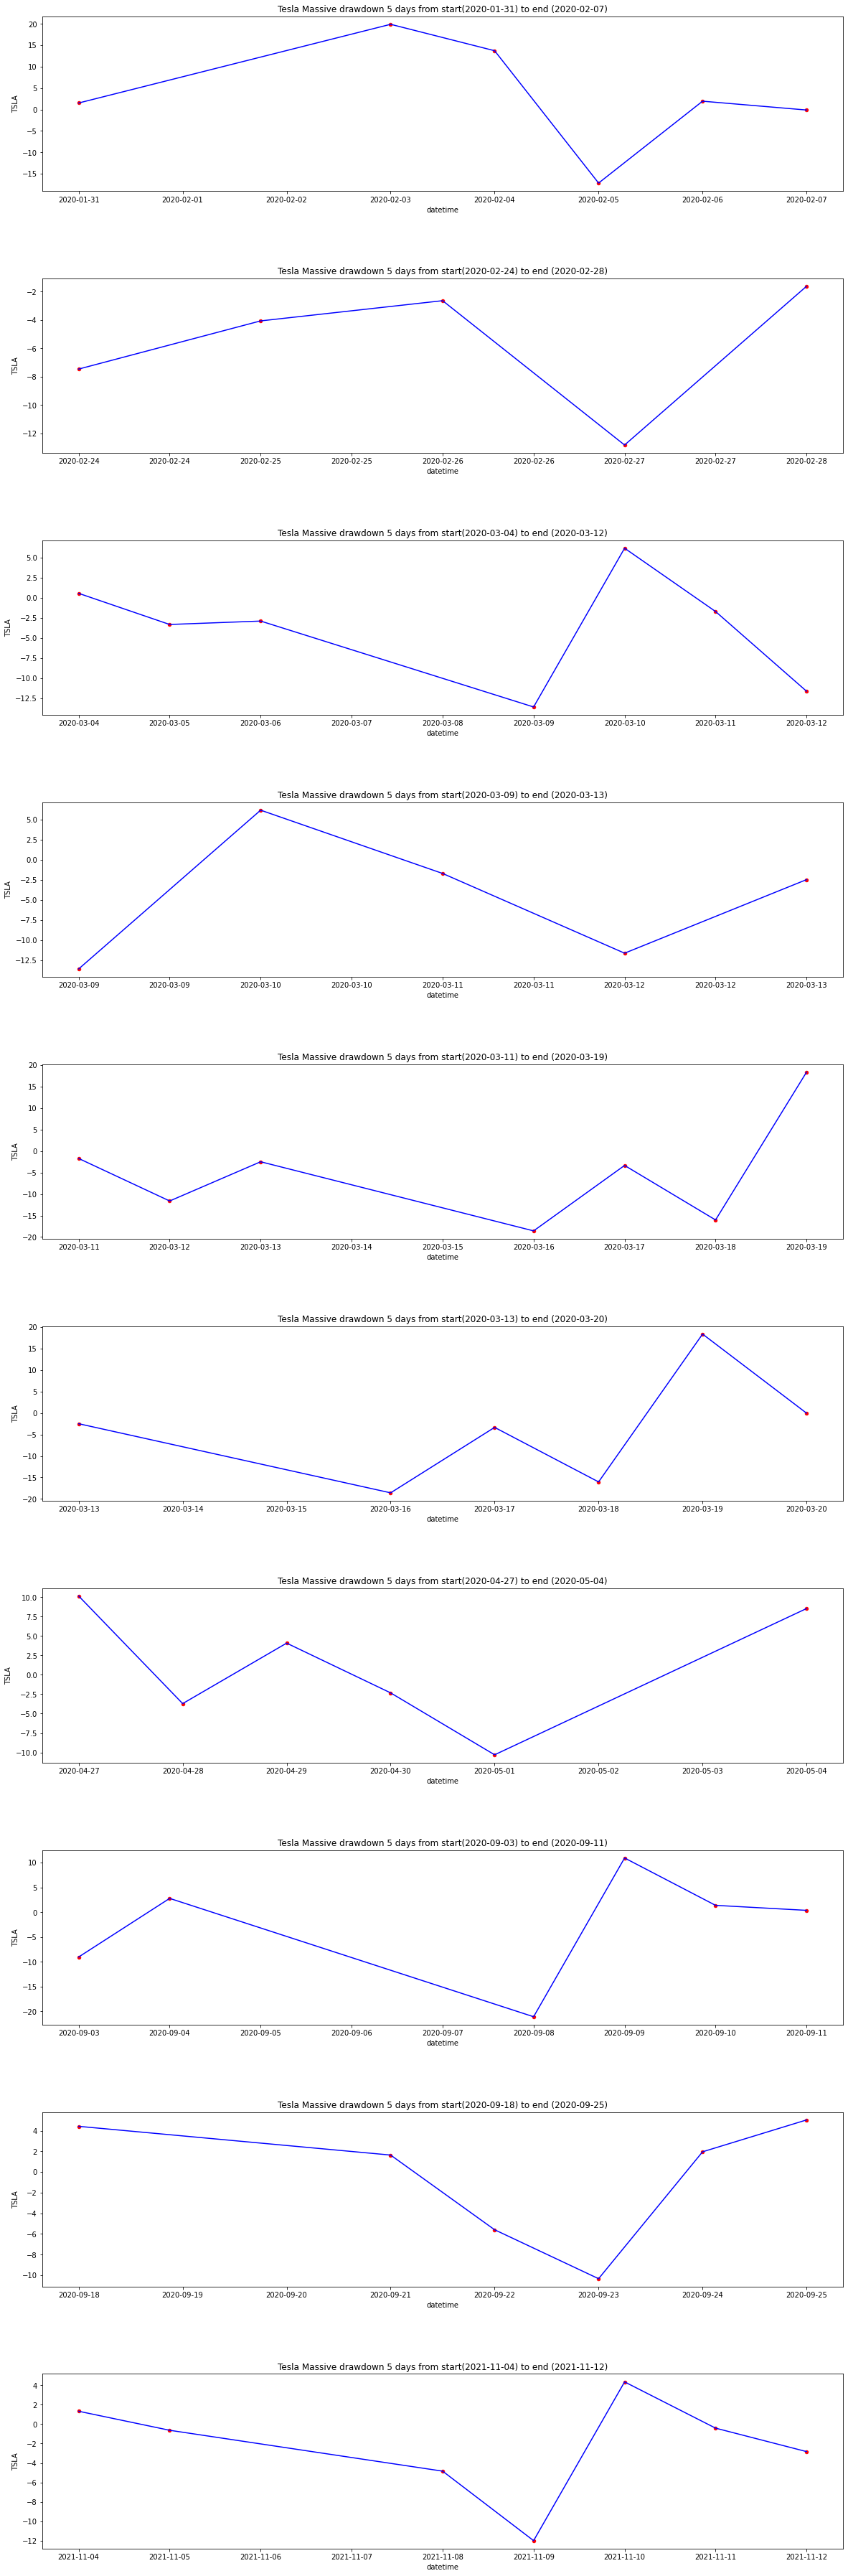

In [11]:
# make dates for the next 3 days, where the dates are given below
dump_dates = tsla_df[(tsla_df < -10) & (tsla_df.index >= pd.Timestamp("2020-01-01"))].index

look_ahead_dates = []
for date in dump_dates:
    d_ranges = [d for d in pd.bdate_range(start=date - pd.Timedelta(days=5), end=date + pd.Timedelta(days=3))]
    look_ahead_dates.append(d_ranges)

fig, ax = plt.subplots(nrows=len(look_ahead_dates), ncols=1, figsize=(20, len(look_ahead_dates) * 5))
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i, look_ahead in enumerate(look_ahead_dates): 
    ax[i] = pd.DataFrame(tsla_df[(tsla_df.index >= look_ahead[0]) & (tsla_df.index <= look_ahead[-1])])\
    .reset_index().plot(ax=ax[i], kind="scatter", x="datetime", y="TSLA", color="r")
    ax[i] = tsla_df[(tsla_df.index >= look_ahead[0]) & (tsla_df.index <= look_ahead[-1])].plot(ax=ax[i], color="b")
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_title(f"Tesla Massive drawdown 5 days from start({str(look_ahead[0].date())}) to end ({str(look_ahead[-1].date())})")

# plt.savefig("TSLA_Massive_drawdowns.png")

<AxesSubplot:xlabel='datetime'>

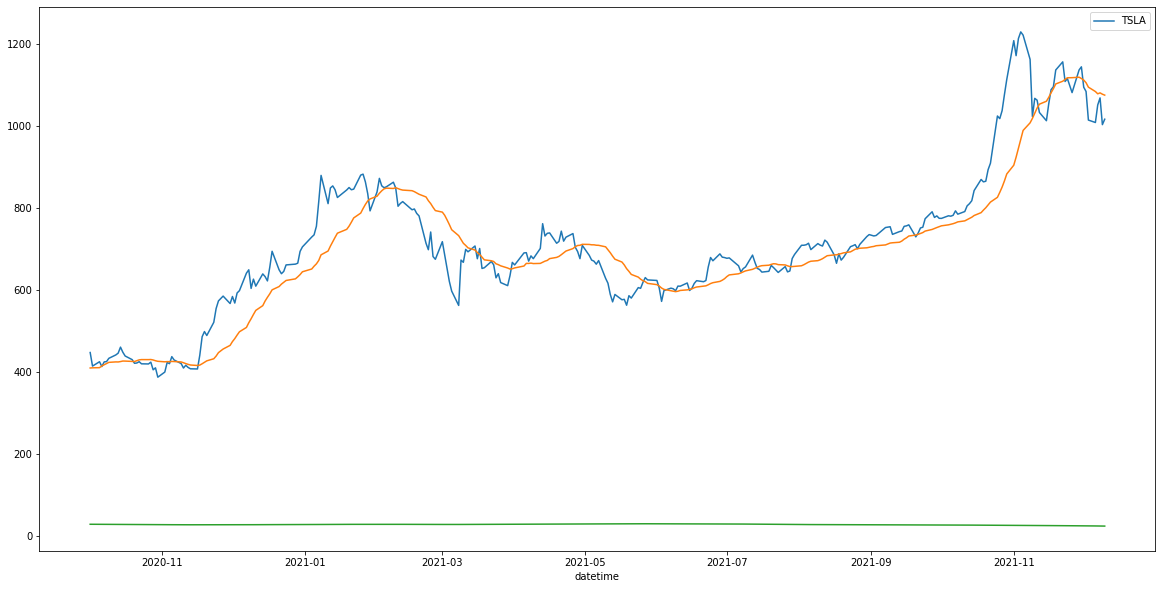

In [13]:
# What happens when TSLA hits the 20sma ?

tickers = ["TSLA"]
tsla_sma = ta.SMA(all_df[tickers[0] if len(tickers) == 1 else tickers], timeperiod=20)
tsla_sma2 = ta.SMA(all_df[ticker[0] if len(tickers) == 1 else tickers], timeperiod=50)
fig2, ax2 = plt.subplots(figsize=(20, 10))

view_start = "2020-10-01"
all_df.loc[all_df.index >= pd.Timestamp(view_start), tickers].plot(ax=ax2)
tsla_sma[tsla_sma.index >= pd.Timestamp(view_start)].plot(ax=ax2)
tsla_sma2[tsla_sma2.index >= pd.Timestamp(view_start)].plot(ax=ax2)

#### Earnings date announcements for ZM

In [17]:
earnings_dates = [
    "Nov 22, 2021", 
    "Aug 30, 2021", 
    "Jun 01, 2021",
    "Mar 01, 2021", 
    "Nov 30, 2020", 
    "Aug 31, 2020", 
    "Jun 02, 2020", 
    "Mar 04, 2020", 
    "Dec 05, 2019", 
    "Sep 05, 2019"
]

earnings_dates = [datetime.datetime.strptime(x, "%b %d, %Y").date() for x in earnings_dates]

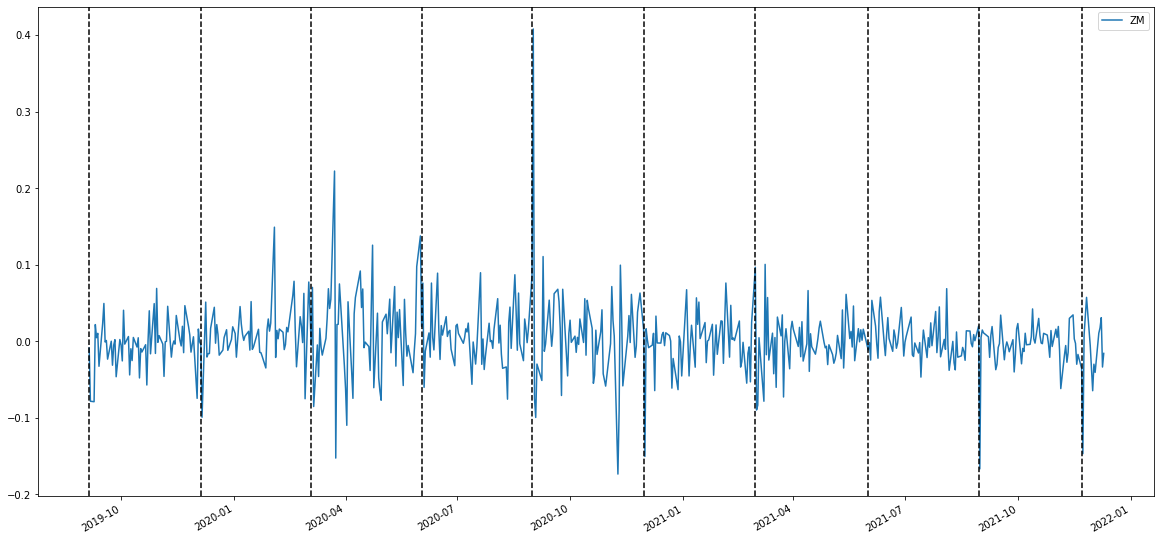

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
tickers = ["ZM"]
returns_df.loc[sorted(earnings_dates)[0]:, tickers].plot(ax=ax)
ax1 = [ax.axvline(x, color='k', linestyle='--') for x in earnings_dates]

### Push into zipline

In [ ]:
all_df.to_csv("../data/all_df.csv")
returns_df.to_csv("../data/returns_df.csv")

In [29]:
all_df

,A,AA,AAA,AAAU,AAC,AAC.U,AAC.WS,AACG,AACIU,AADI,...,ZUO,ZVIA,ZVO,ZWRK,ZWRKU,ZWRKW,ZY,ZYME,ZYNE,ZYXI
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-02,40.56,47.64,NaN,NaN,30.21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,39.80,44.88,NaN,NaN,29.73,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,39.18,45.21,NaN,NaN,29.38,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,39.70,46.38,NaN,NaN,28.64,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,40.89,47.70,NaN,NaN,29.37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-03,179.28,47.21,25.005,18.1898,9.72,9.90,0.9500,2.77,NaN,27.59,...,18.40,16.91,2.55,NaN,9.85,0.6494,14.035,32.47,4.45,13.18
2021-09-07,177.72,46.77,25.005,17.8400,9.72,9.90,0.9500,2.82,9.85,26.48,...,18.00,16.12,2.57,NaN,9.85,0.6700,13.380,32.04,4.46,13.12
2021-09-08,178.73,45.73,25.005,17.7800,9.71,9.88,0.9469,2.71,NaN,27.67,...,17.12,14.21,2.39,NaN,NaN,0.6199,13.180,31.99,4.32,12.90


### Caterpillar

In [88]:
import io
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

urls = ["http://www.cryptodatadownload.com/cdd/gemini_BTCUSD_1hr.csv", ]
response = requests.get(btc_url, verify=False).content
btc_df = pd.read_csv(io.StringIO(response.decode('utf-8')), skiprows=1)

btc_df = btc_df.drop(columns=["Unix Timestamp"], inplace=False)
btc_df.columns = [x.lower() for x in btc_df.columns.tolist()]
btc_df.loc[:, "date"] = pd.to_datetime(btc_df["date"])
btc_df = btc_df.sort_values(by="date", ascending=True)
btc_df = btc_df.reset_index(inplace=False, drop=True)
btc_df = btc_df.set_index("date")

In [129]:
dur_past, dur_pred, n_similar = 14, 28, 5

price_change = (btc_df["close"] / btc_df["close"].shift(1)).fillna(0.0)
price_tail = price_change.tail(14)
price_err = [0] * ( len(price_change) - dur_past - dur_pred )

In [167]:
for i in tqdm(range(1, len(price_err))):
    price_err[i] = mean_squared_error(y_true=price_tail, y_pred=price_change[0 + (i - 1): (dur_past + (i - 1))], squared=False)

  0%|          | 0/51830 [00:00<?, ?it/s]

In [168]:
price_err

[0,
 0.267022984482203,
 0.01919198340319353,
 0.01792435602042921,
 0.018647393081803652,
 0.018872585637371132,
 0.018589794837170256,
 0.01884185337334251,
 0.018670652323728314,
 0.018408996094188675,
 0.018716106223480872,
 0.018756344752161477,
 0.018757698854724274,
 0.018750307750208296,
 0.018723884045121677,
 0.018790291620336144,
 0.018727336143936683,
 0.018804811780802597,
 0.018758290028497774,
 0.020204569226604685,
 0.0200342421299385,
 0.02017008969852802,
 0.021570454670850604,
 0.019894833313420547,
 0.02108492787173195,
 0.019526895470236942,
 0.02193218917260392,
 0.017760519096240747,
 0.022991319271182517,
 0.024378238072106158,
 0.016709225562527758,
 0.019985247659445312,
 0.020690086011411698,
 0.01920391548120709,
 0.018851603349988196,
 0.0187953026965501,
 0.018865056930472517,
 0.01864893697104658,
 0.01876685543719162,
 0.018758492181036243,
 0.018837352321458955,
 0.01862164854390269,
 0.018942040534088135,
 0.01875691012687386,
 0.017790535375682013,
 0

In [165]:
closest_predictions = sorted(price_err)[:5]
closest_predictions_incides = [list(np.argwhere(price_err == ele))[0][0] if len(np.argwhere(price_err == ele)) > 0 else 0.0001 for ele in closest_predictions ]

In [160]:
weighted_preds = [0] * dur_pred

In [163]:
1/sum(closest_predictions)

3870.9131856506224

In [166]:
for i in range(n_similar):
    weighted_preds += price_change[(dur_past + closest_predictions_incides[i]): (dur_past + dur_pred + closest_predictions_incides[i] - 1)] * ( (1/closest_predictions[i]) / 1/sum(closest_predictions))

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [14.0001] of type float